# Part IV: Analysis & Visualisation

## Load Required Packages

In [1]:
import pandas as pd
import json
from pandas import json_normalize
import regex
import re
import numpy as np
import datetime as dt

# Packages for visualizing
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

import scipy.stats as stats

## Load Data

In [2]:
labelled_posts = pd.read_excel("labs_labelled_posts_new.xlsx")

In [3]:
model_labelled_posts = pd.read_csv("model_labelled_posts.csv")

In [4]:
labelled_comments = pd.read_excel("labs_labelled_comments.xlsx")

In [5]:
model_labelled_comments = pd.read_csv("model_labelled_comments.csv")

# Create the Data Frames for Analysis 

## Posts:

#### Manually Labelled Posts:

In [6]:
# Examine labelled posts
labelled_posts.head()

,Unnamed: 0,label_threat,label_vict,moral_label,post_id,title,date
0,5153,0,1,1,7lsb6z,Nebraska motel managers plead guilty to enslav...,2017-12-24
1,3023,0,0,0,5unes0,AP Exclusive: DHS weighed Nat Guard for immigr...,2017-02-17
2,6797,1,0,1,8ve0wu,Illegal immigrant arrested for starting wildfi...,2018-07-02
3,9529,0,1,1,evzc7o,Recruiter for ICE’s fake university sentenced ...,2020-01-30
4,7907,1,0,1,an5m4t,Honda Jet guilty of not hiring immigrants with...,2019-02-04


In [7]:
# Remove columns that are not needed (Unnamed:0 are the old index numbers, however, as we have post_id, 
# these are not needed)
labelled_posts = labelled_posts.drop(columns = ["Unnamed: 0", "label_threat", "label_vict"])

In [8]:
# Rearrange df columns for appending to classifier labelled posts
newcolumnorder = ["post_id", "title", "date", "moral_label"]
labelled_posts = labelled_posts[newcolumnorder]

In [9]:
# Examine final labelled table
labelled_posts.head()

,post_id,title,date,moral_label
0,7lsb6z,Nebraska motel managers plead guilty to enslav...,2017-12-24,1
1,5unes0,AP Exclusive: DHS weighed Nat Guard for immigr...,2017-02-17,0
2,8ve0wu,Illegal immigrant arrested for starting wildfi...,2018-07-02,1
3,evzc7o,Recruiter for ICE’s fake university sentenced ...,2020-01-30,1
4,an5m4t,Honda Jet guilty of not hiring immigrants with...,2019-02-04,1


#### Classifier Labelled Posts:

In [10]:
# Examine classifier labelled posts 
model_labelled_posts.head()

,Unnamed: 0.1,Unnamed: 0,post_id,title,date,moral_labels
0,0,6807,8vjh0c,Alabama man arrested after shouting 'womp womp...,2018-07-02,1
1,1,10965,nznzfc,U.S. to expand work permits for immigrants who...,2021-06-14,1
2,2,2832,5tavj7,"Undocumented Immigrants Arrested Across U.S., ...",2017-02-11,0
3,3,5587,7vlzmh,Best Immigration Consultant in Melbourne,2018-02-06,0
4,4,5413,7qyig9,Don Lemon Dumbfounded By Jeff Session's Commen...,2018-01-17,0


In [11]:
# Remove columns that are not needed and rename moral_labels to moral_label for appending the data
model_labelled_posts = model_labelled_posts.drop(
    columns = ["Unnamed: 0.1", "Unnamed: 0"]).rename(
    columns = {"moral_labels":"moral_label"}) 

In [12]:
# Examine final table:
model_labelled_posts.head()

,post_id,title,date,moral_label
0,8vjh0c,Alabama man arrested after shouting 'womp womp...,2018-07-02,1
1,nznzfc,U.S. to expand work permits for immigrants who...,2021-06-14,1
2,5tavj7,"Undocumented Immigrants Arrested Across U.S., ...",2017-02-11,0
3,7vlzmh,Best Immigration Consultant in Melbourne,2018-02-06,0
4,7qyig9,Don Lemon Dumbfounded By Jeff Session's Commen...,2018-01-17,0


#### Combined Posts Dataset: 

In [13]:
allposts = model_labelled_posts.append(labelled_posts)

/var/folders/2w/bw2mbvzn6ns_37v4dn94xthm0000gn/T/ipykernel_37342/903783430.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allposts = model_labelled_posts.append(labelled_posts)


In [14]:
len(allposts)

5708

In [15]:
# check if this is correct
print (f"Is the combined post df of equal length as the human labelled and classifier labelled post df? - {len(allposts)==len(labelled_posts)+len(model_labelled_posts)}") 

Is the combined post df of equal length as the human labelled and classifier labelled post df? - True


#### Add labelling with "neutral" and "moralised" (corresponding to 0 and 1)

In [16]:
allposts["moral_label_w"] = allposts["moral_label"].replace({0:"Neutral", 1:"Moralised"})

#### Extract year from posts

In [17]:
allposts["year"] = pd.DatetimeIndex(allposts["date"]).year

## Comments:

#### Manually labelled dataset:

In [18]:
labelled_comments.head()

,Unnamed: 0,post_id,comment_id,AP_label,AP_inciv,AP_group,comment
0,5513,5uq3hi,ddwiqvl,1,1,1,They couldn't have worked something out in adv...
1,1372,40rytx,cywy5j8,1,1,1,"Well yeah, with no conceal and carry to protec..."
2,14515,b1pe5m,eiovpa5,1,1,0,I'd love to see somebody choke the fuck out Br...
3,5450,5uq3hi,ddwh9p6,0,0,0,in the UK this would be a textbook case of unf...
4,19859,ex0ttq,fgbu7t7,0,0,0,"Illegal aliens, you mean?"


In [19]:
# Remove columns that are not needed (Unnamed:0, AP_inciv, AP_group)
labelled_comments = labelled_comments.drop(columns = ["Unnamed: 0", "AP_inciv", "AP_group"])

In [20]:
# Change column order so labels are at the end of the df as in the model_labelled_comments df
newcolumnorder = ["post_id", "comment_id", "comment", "AP_label"]
labelled_comments = labelled_comments[newcolumnorder]

In [21]:
labelled_comments.head()

,post_id,comment_id,comment,AP_label
0,5uq3hi,ddwiqvl,They couldn't have worked something out in adv...,1
1,40rytx,cywy5j8,"Well yeah, with no conceal and carry to protec...",1
2,b1pe5m,eiovpa5,I'd love to see somebody choke the fuck out Br...,1
3,5uq3hi,ddwh9p6,in the UK this would be a textbook case of unf...,0
4,ex0ttq,fgbu7t7,"Illegal aliens, you mean?",0


#### Classifier labelled dataset

In [22]:
model_labelled_comments.head()

,Unnamed: 0.1,Unnamed: 0,post_id,comment_id,comment,AP_labels
0,0,0,flgxp,c1gtf8n,I don't advocate the death penalty. But this ...,0
1,1,1,flgxp,c1gtjcm,Did anybody else see [this video](/david-neiwe...,0
2,2,2,flgxp,c1gtlbj,I've been following this case for a while. I'm...,0
3,3,4,flgxp,c1gtnqs,Good.,0
4,4,5,flgxp,c1gtnuc,Fry that bitch!,0


In [23]:
# Remove columns that are not needed (Unnamed:0, AP_inciv, AP_group)
model_labelled_comments = model_labelled_comments.drop(
    columns = ["Unnamed: 0.1","Unnamed: 0"]).rename(
    columns = {"AP_labels":"AP_label"}) 

In [24]:
model_labelled_comments.head()

,post_id,comment_id,comment,AP_label
0,flgxp,c1gtf8n,I don't advocate the death penalty. But this ...,0
1,flgxp,c1gtjcm,Did anybody else see [this video](/david-neiwe...,0
2,flgxp,c1gtlbj,I've been following this case for a while. I'm...,0
3,flgxp,c1gtnqs,Good.,0
4,flgxp,c1gtnuc,Fry that bitch!,0


#### Dataset with both comments

In [25]:
allcomments = model_labelled_comments.append(labelled_comments)

/var/folders/2w/bw2mbvzn6ns_37v4dn94xthm0000gn/T/ipykernel_37342/3636821257.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  allcomments = model_labelled_comments.append(labelled_comments)


In [26]:
# check if appending worked
print (f"Is the combined post df of equal length as the human labelled and classifier labelled comments df? - {len(allcomments)==len(labelled_comments)+len(model_labelled_comments)}") 

Is the combined post df of equal length as the human labelled and classifier labelled comments df? - True


#### Merge Post & Comments Dfs

Using the post_id to join the comments to the posts, dropping any NAs that may have been introduced while retrieving the comments corresponding to the posts from the archived dataset. 

In [27]:
posts_comments = allcomments.merge(allposts, how = "left", on = ["post_id"]).dropna()

In [28]:
posts_comments.head()

,post_id,comment_id,comment,AP_label,title,date,moral_label,moral_label_w,year
0,flgxp,c1gtf8n,I don't advocate the death penalty. But this ...,0,Arizona vigilante/anti-illegal immigration act...,2011-02-14,1.0,Moralised,2011.0
1,flgxp,c1gtjcm,Did anybody else see [this video](/david-neiwe...,0,Arizona vigilante/anti-illegal immigration act...,2011-02-14,1.0,Moralised,2011.0
2,flgxp,c1gtlbj,I've been following this case for a while. I'm...,0,Arizona vigilante/anti-illegal immigration act...,2011-02-14,1.0,Moralised,2011.0
3,flgxp,c1gtnqs,Good.,0,Arizona vigilante/anti-illegal immigration act...,2011-02-14,1.0,Moralised,2011.0
4,flgxp,c1gtnuc,Fry that bitch!,0,Arizona vigilante/anti-illegal immigration act...,2011-02-14,1.0,Moralised,2011.0


In [29]:
posts_comments["moral_label_w"] = posts_comments["moral_label"].replace({0:"Neutral", 1:"Moralised"})

In [30]:
posts_comments["AP_label_w"] = posts_comments["AP_label"].replace({0:"Other", 1:"AP_markers"})

### Extract year and month from date column for analysis

In [31]:
posts_comments["year"] = pd.DatetimeIndex(posts_comments["date"]).year

In [32]:
posts_comments["month"] = pd.DatetimeIndex(posts_comments["date"]).month

# Descriptives

### What is the date range in the random sample of posts and corresponding comments?

In [33]:
earliest = posts_comments["date"].min()
latest = posts_comments["date"].max()
print(f"the posts in this dataset range from {earliest} to {latest}")

the posts in this dataset range from 2011-02-14 to 2022-12-21


### When it comes to immigration, are there more moralised titles, or non-moralised titles?

### In absolute terms:

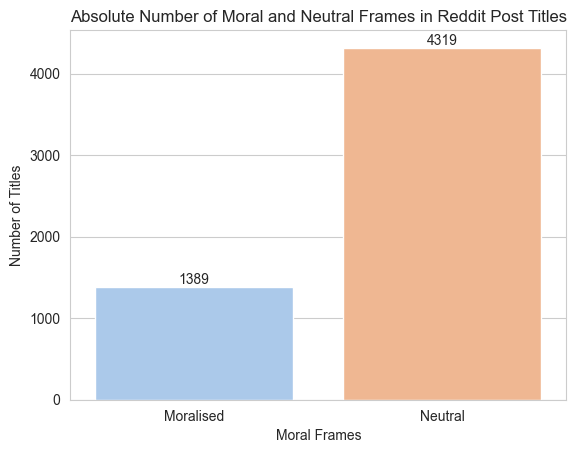

In [34]:
# set plot style
sns.set_style("whitegrid")

# create plot and store as object
posts_moral_prevalence = sns.countplot(data = allposts, x = "moral_label_w", 
                                      palette="pastel")

# specify plot labels & title 
plt.xlabel("Moral Frames")
plt.ylabel("Number of Titles")
plt.title("Absolute Number of Moral and Neutral Frames in Reddit Post Titles")

# Add values to the bar plot
posts_moral_prevalence.bar_label(posts_moral_prevalence.containers[0])

#save to .png
plt.savefig("prevalence_moralframes_overall.png", bbox_inches="tight")

#show plot
plt.show(posts_moral_prevalence)

### In relative terms:

In [35]:
# function to get relative number of a variable
def get_relative (df, count, totalcount, final_column_name):
    df[final_column_name] = df[count]/totalcount
    return df

In [36]:
relative_moral = allposts.groupby(["year", "moral_label_w"]).size().reset_index(name="Count")

In [37]:
total_count = relative_moral.groupby("year")["Count"].transform(lambda x: x.sum())

In [38]:
get_relative(relative_moral, "Count", total_count, "relative_numbers")

,year,moral_label_w,Count,relative_numbers
0,2011,Moralised,1,1.000000
1,2012,Moralised,1,1.000000
2,2013,Moralised,1,0.500000
3,2013,Neutral,1,0.500000
4,2014,Moralised,4,0.666667
5,2014,Neutral,2,0.333333
6,2015,Moralised,3,0.600000
7,2015,Neutral,2,0.400000
8,2016,Moralised,180,0.193340
9,2016,Neutral,751,0.806660


In [39]:
relative_moral_agg = relative_moral.groupby(["moral_label_w"]).agg(
    mean_rel_moral = ("relative_numbers", "mean")).round(decimals = 2)

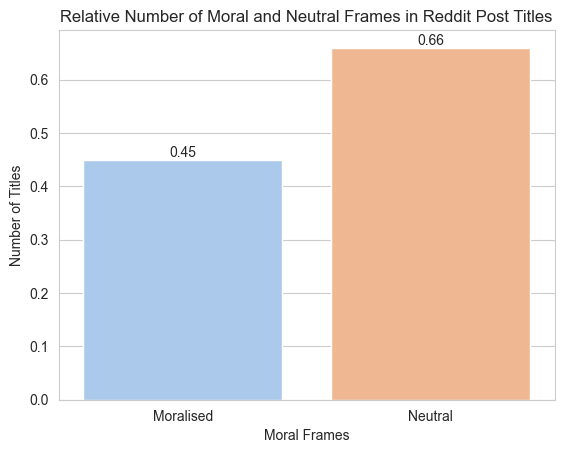

In [40]:
relative_moral_agg = relative_moral_agg.reset_index()

# set plot style
sns.set_style("whitegrid")

# create plot and store as object
posts_moral_prevalence = sns.barplot(data = relative_moral_agg, x = "moral_label_w", y = "mean_rel_moral", 
                                      palette="pastel")

# specify plot labels & title 
plt.xlabel("Moral Frames")
plt.ylabel("Number of Titles")
plt.title("Relative Number of Moral and Neutral Frames in Reddit Post Titles")

# Add values to the bar plot
posts_moral_prevalence.bar_label(posts_moral_prevalence.containers[0])

#save to .png
plt.savefig("posts_moral_prevalence.png", bbox_inches="tight")

#show plot
plt.show(posts_moral_prevalence)

## Has the number of moral frames in Reddit posts changed over time?

### In absolute terms:

In [41]:
# Sort by year in ascending order:
allposts_time = allposts.sort_values(by=["year"])

In [42]:
allposts_time = allposts.groupby(["year", "moral_label_w"]).size().reset_index(name="count")

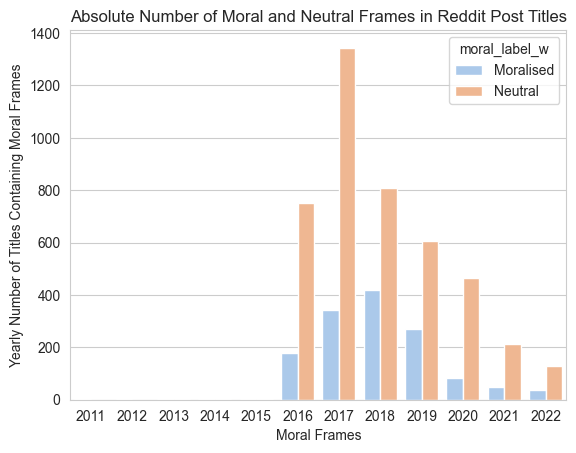

In [43]:
# set plot style: 
sns.set_style("whitegrid") 

posts_yearly_prev = sns.barplot(x="year", y="count", hue="moral_label_w", data=allposts_time, 
                               palette="pastel")

# specify plot labels & title 
plt.xlabel("Moral Frames")
plt.ylabel("Yearly Number of Titles Containing Moral Frames")
plt.title("Absolute Number of Moral and Neutral Frames in Reddit Post Titles")

#save to .png
plt.savefig("prevalence_moralframes_yearly.png", bbox_inches="tight")

#show plot
plt.show(posts_yearly_prev)

### In relative terms:

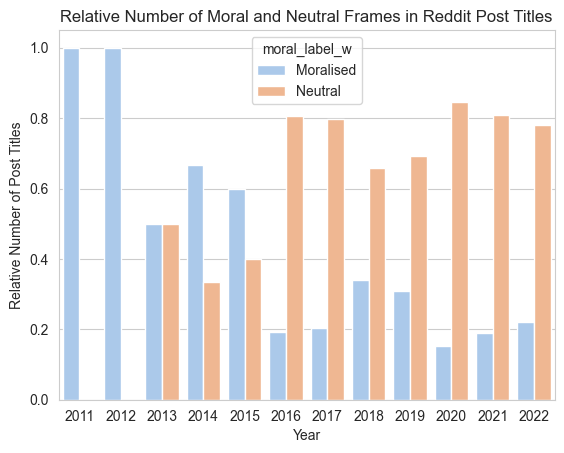

In [44]:
# set plot style: 
sns.set_style("whitegrid") 

posts_yearly_rel = sns.barplot(x="year", y="relative_numbers", hue="moral_label_w", data=relative_moral, 
                              palette="pastel")

# specify plot labels & title 
plt.xlabel("Year")
plt.ylabel("Relative Number of Post Titles")
plt.title("Relative Number of Moral and Neutral Frames in Reddit Post Titles")

#save to .png
plt.savefig("posts_yearly_rel.png", bbox_inches="tight")

#show plot
plt.show(posts_yearly_rel)

## How has the Relative Number of Affectively Polarised Language Developed Over Time?

Comments are only examined in relative terms, as they are nested within posts, which can have differing absolute numbers of comments.

In [45]:
ap_post_year = posts_comments.groupby(["post_id", "year", "AP_label_w"]).size().reset_index(name="Count")

In [46]:
total_ap_post_year = ap_post_year.groupby(["year", "post_id"])["Count"].transform(lambda x: x.sum())

In [47]:
get_relative(ap_post_year, "Count", total_ap_post_year, "relative_number")

,post_id,year,AP_label_w,Count,relative_number
0,166new,2013,AP_markers,15,0.405405
1,166new,2013,Other,22,0.594595
2,1lkjlq,2013,AP_markers,32,0.395062
3,1lkjlq,2013,Other,49,0.604938
4,26d4s8,2014,AP_markers,15,0.312500
...,...,...,...,...,...
1662,zf28mm,2022,AP_markers,37,0.282443
1663,zf28mm,2022,Other,94,0.717557
1664,zf9rn7,2022,Other,1,1.000000
1665,zr4tbg,2022,AP_markers,2,0.400000


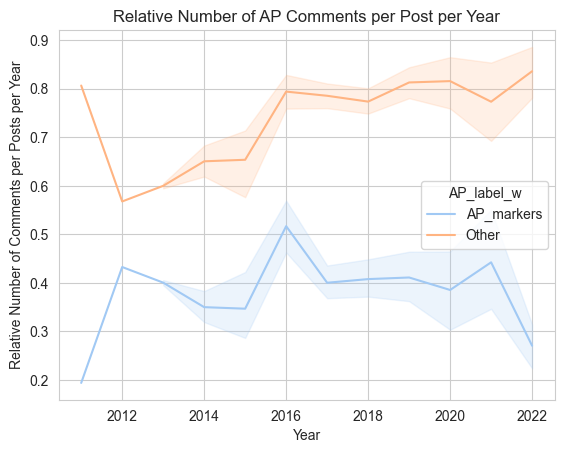

In [48]:
# set plot style: 
sns.set_style("whitegrid") 

rel_com_y = sns.lineplot(x="year", y="relative_number", hue="AP_label_w", data=ap_post_year, 
                        palette="pastel")

# specify plot labels & title 
plt.xlabel("Year")
plt.ylabel("Relative Number of Comments per Posts per Year")
plt.title("Relative Number of AP Comments per Post per Year")

#save to .png
plt.savefig("rel_com_y.png", bbox_inches="tight")

#show plot
plt.show(rel_com_y)

## Are there overall differences in affectively polarised language between posts that are framed neutrally, and posts that contain moral framing about Immigration?

In [49]:
#Group by post ID, moral framing of posts & AP indicators in comments to get the absolute count of
# comments containing AP markers vs. those that don't per post, as well as the moral frames of the posts.
ap_post_overall = posts_comments.groupby(["post_id", "moral_label_w", "AP_label"]).size().reset_index(name="Count")

In [50]:
#Group by post_id to get absolute numbers of comments per post
total_count = ap_post_overall.groupby(["post_id"])["Count"].transform(lambda x: x.sum())

In [51]:
# compute relative frequency of AP categories per post
get_relative(ap_post_overall, "Count", total_count, "relative_number_comments")

,post_id,moral_label_w,AP_label,Count,relative_number_comments
0,166new,Neutral,0,22,0.594595
1,166new,Neutral,1,15,0.405405
2,1lkjlq,Moralised,0,49,0.604938
3,1lkjlq,Moralised,1,32,0.395062
4,26d4s8,Moralised,0,33,0.687500
...,...,...,...,...,...
1662,zf28mm,Neutral,0,94,0.717557
1663,zf28mm,Neutral,1,37,0.282443
1664,zf9rn7,Moralised,0,1,1.000000
1665,zr4tbg,Neutral,0,3,0.600000


### T-Test:

In [52]:
ap_test = posts_comments.groupby(["post_id", "moral_label", "AP_label"]).size().reset_index(name="Count")

In [53]:
#Group by post_id to get absolute numbers of comments per post
total_count = ap_test.groupby(["post_id"])["Count"].transform(lambda x: x.sum())

In [54]:
# compute relative frequency of AP categories per post
get_relative(ap_test, "Count", total_count, "relative_number_comments")

,post_id,moral_label,AP_label,Count,relative_number_comments
0,166new,0.0,0,22,0.594595
1,166new,0.0,1,15,0.405405
2,1lkjlq,1.0,0,49,0.604938
3,1lkjlq,1.0,1,32,0.395062
4,26d4s8,1.0,0,33,0.687500
...,...,...,...,...,...
1662,zf28mm,0.0,0,94,0.717557
1663,zf28mm,0.0,1,37,0.282443
1664,zf9rn7,1.0,0,1,1.000000
1665,zr4tbg,0.0,0,3,0.600000


In [55]:
apt = ap_test[ap_test["AP_label"] == 1]

In [56]:
# import stats
stats.ttest_ind(apt["relative_number_comments"][apt["moral_label"] == 0.0],
                apt["relative_number_comments"][apt["moral_label"] == 1.0])

Ttest_indResult(statistic=0.09578611931111038, pvalue=0.9237189984226456)

In [57]:
ap_post_overall_val = ap_post_overall.loc[ap_post_overall.AP_label==1].groupby(["moral_label_w"]).agg(
    mean_rel_AP = (
    "relative_number_comments", "mean"),
    std_rel_AP = ("relative_number_comments", "std")).round(decimals=3)

In [58]:
ap_post_overall_val

,mean_rel_AP,std_rel_AP
moral_label_w,,
Moralised,0.417,0.237
Neutral,0.419,0.264


No significant difference was found in the relative prevalence of language containing indicators of affective polarisation between moral (M=0.42, SD=.24) and neutral posts (M=0.42, SD=.26)

### Visualising the result:

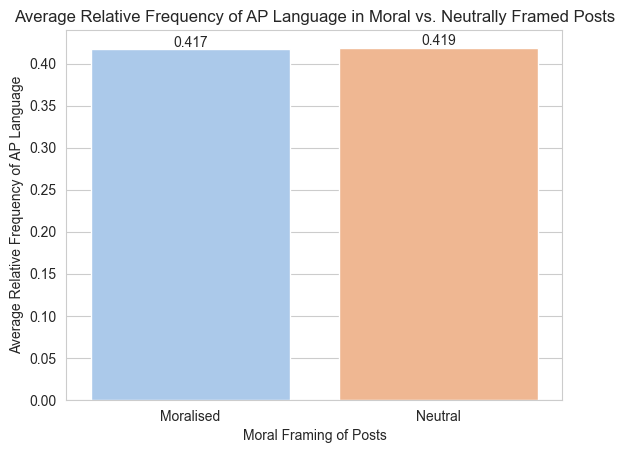

In [59]:
ap_post_overall_val = ap_post_overall_val.reset_index()

# set plot style: 
sns.set_style("whitegrid") 

ap_post_overall_plot = sns.barplot(data=ap_post_overall_val, x="moral_label_w", y="mean_rel_AP", 
                                  palette="pastel")

# Add values to the bar plot
ap_post_overall_plot.bar_label(ap_post_overall_plot.containers[0])

# specify plot labels & title 
plt.xlabel("Moral Framing of Posts")
plt.ylabel("Average Relative Frequency of AP Language")
plt.title("Average Relative Frequency of AP Language in Moral vs. Neutrally Framed Posts")

#save to .png
plt.savefig("ap_post_overall_plot.png", bbox_inches="tight")

#show plot
plt.show(ap_post_overall_plot)

### Over-time development of differences in affectively polarised language between posts that are framed neutrally, and posts that contain moral framing about Immigration

In [60]:
#Group by post ID, moral framing of posts & AP indicators in comments to get the absolute count of
# comments containing AP markers vs. those that don't per post, as well as the moral frames of the posts.
ap_post_YY = posts_comments.groupby(["year", "post_id", "moral_label_w", "AP_label"]).size().reset_index(name="Count")

In [61]:
#Group by post_id to get absolute numbers of comments per post
#ap_post_YY["absolute_comments"] = ap_post_YY.groupby(["post_id"])["Count"].transform(lambda x: x.sum())
total_count = ap_post_YY.groupby(["post_id"])["Count"].transform(lambda x: x.sum())

In [62]:
get_relative(ap_post_YY, "Count", total_count, "relative_number_comments")

,year,post_id,moral_label_w,AP_label,Count,relative_number_comments
0,2011,flgxp,Moralised,0,50,0.806452
1,2011,flgxp,Moralised,1,12,0.193548
2,2012,v3ep3,Moralised,0,21,0.567568
3,2012,v3ep3,Moralised,1,16,0.432432
4,2013,166new,Neutral,0,22,0.594595
...,...,...,...,...,...,...
1662,2022,zf28mm,Neutral,0,94,0.717557
1663,2022,zf28mm,Neutral,1,37,0.282443
1664,2022,zf9rn7,Moralised,0,1,1.000000
1665,2022,zr4tbg,Neutral,0,3,0.600000


In [63]:
ap_post_YY = ap_post_YY.loc[ap_post_YY.AP_label==1].groupby(
    ["year", "moral_label_w"]).agg(
    mean_rel_AP = (
    "relative_number_comments", "mean"))

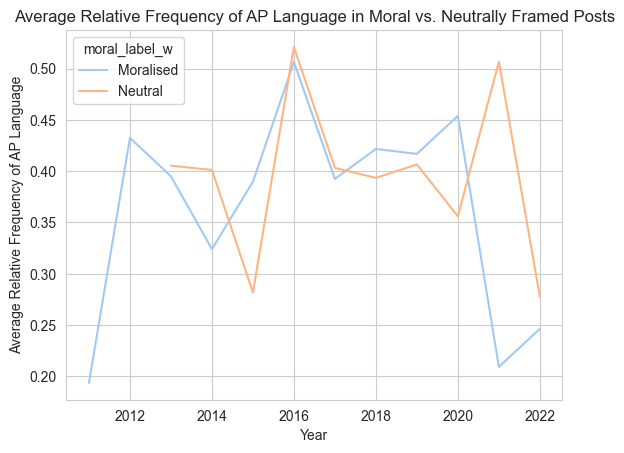

In [64]:
ap_post_YY = ap_post_YY.reset_index()

# set plot style: 
sns.set_style("whitegrid") 

ap_post_YY_plot = sns.lineplot(data=ap_post_YY, x="year", y="mean_rel_AP", hue="moral_label_w", 
                              palette="pastel")

# specify plot labels & title 
plt.xlabel("Year")
plt.ylabel("Average Relative Frequency of AP Language")
plt.title("Average Relative Frequency of AP Language in Moral vs. Neutrally Framed Posts")

#save to .png
plt.savefig("ap_post_YY_plot.png", bbox_inches="tight")

#show plot
plt.show(ap_post_YY_plot)

# Training & Validation Loss Curves from the BERT Models

## Moral Bert:

#### Five Epochs:

In [65]:
#(FROM FINAL RUN MORAL BERT)
# These had to be hand coded because I was unable to get extract the individual values.
training_loss = [0.6104, 0.5135, 0.5477, 0.4778, 
                0.3510, 0.3597,0.3383, 0.238100,
                0.1420, 0.1840, 0.4010, 0.14460, 
                0.1049, 0.22360, 0.0801, 0.0035, 
                0.0582, 0.0420]

validation_loss = [0.579096, 0.548197, 0.507165, 
                  0.465717, 0.460456, 0.509234, 
                  0.681263, 0.772730, 0.843409, 
                  0.838558, 0.713522, 0.727510, 
                  1.055032, 0.855415, 0.852997, 
                  0.908388, 0.925053, 0.930002]

steps = [20, 40, 60, 80, 100, 120, 140, 160, 180, 
        200, 220, 240, 260, 280, 300, 320, 340, 
        360]

f1 = [0.333333, 0.463043, 0.430363, 0.766985, 0.715680,
     0.696950, 0.664268, 0.708116, 0.777667, 0.760963, 
     0.743461, 0.744007, 0.627503, 0.727479, 0.717798, 
     0.721029, 0.721029, 0.721029]

In [66]:
moral_bert = pd.DataFrame({'training_loss':training_loss, 'validation_loss':validation_loss,
                          'steps':steps, 'f1':f1})

In [67]:
moral_bert=moral_bert.melt(id_vars = "steps",
                            var_name = "category", 
                            value_name = "value")

In [68]:
moral_bert_sorted = moral_bert.sort_values(by='steps')

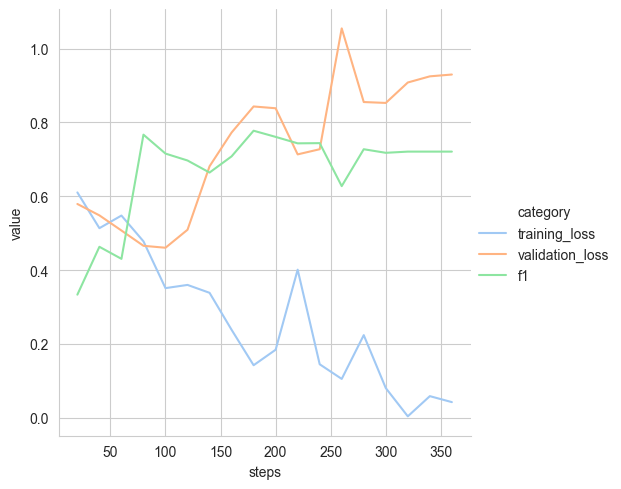

In [69]:
sns.set_style("whitegrid") 
sns.relplot(moral_bert_sorted, x="steps", y = "value", hue="category", kind="line", 
           palette = "pastel")

Setting the training epochs to 5, from this graph it becomes clear that the moralisation model begins overfitting much earlier, at around step 80. Therefore, the step cutoff point for the final model was set to 2. 

#### Two Epochs:

In [70]:
# FROM FINAL COMM MORAL BERT
training_loss = [0.628000, 0.503600, 0.552000, 
                0.516800, 0.388100, 0.347600, 
                0.318600]

validation_loss = [0.547965, 0.488165, 0.493076, 
                  0.450124, 0.534255, 0.433551, 
                  0.429269]

steps = [20, 40, 60, 80, 100, 120, 140]


f1 = [0.333333, 0.582995, 0.591043, 0.657204, 
     0.529983, 0.685359, 0.649333]

In [71]:
moral_bert_RE = pd.DataFrame({'training_loss':training_loss, 'validation_loss':validation_loss,
                          'steps':steps, 'f1':f1})

In [72]:
moral_bert_RE.head()

,training_loss,validation_loss,steps,f1
0,0.6280,0.547965,20,0.333333
1,0.5036,0.488165,40,0.582995
2,0.5520,0.493076,60,0.591043
3,0.5168,0.450124,80,0.657204
4,0.3881,0.534255,100,0.529983


In [73]:
moral_bert_RE=moral_bert_RE.melt(id_vars = "steps",
                            var_name = "category", 
                            value_name = "value")

In [74]:
moral_bert_RE_sorted = moral_bert_RE.sort_values(by='steps')

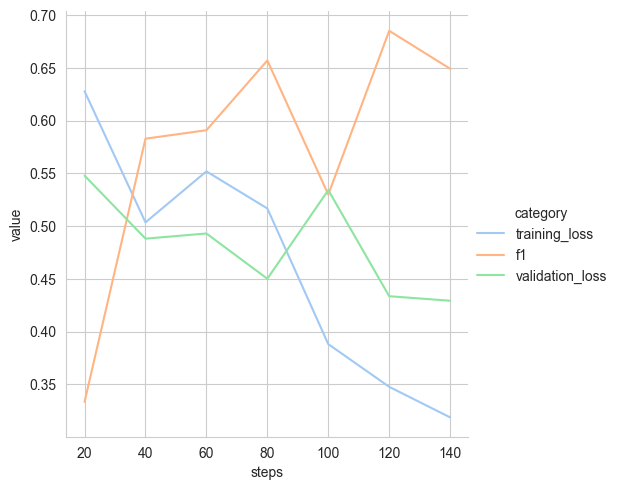

In [75]:
sns.set_style("whitegrid") 
sns.relplot(moral_bert_RE_sorted, x="steps", y = "value", hue="category", kind="line", 
           palette = "pastel")

## Polarisation BERT

### Five Epochs:

In [76]:
# FROM FINAL COMM MORAL BERT
training_loss = [0.493800, 0.576800, 0.504300, 
                0.528500, 0.434100, 0.403500, 
                0.388500, 0.274100, 0.214900, 
                0.421400, 0.132500, 0.127000, 
                0.088000, 0.131000, 0.054400,
                0.003700, 0.072800, 0.001500]

validation_loss = [0.579262, 0.552687, 0.568991,
                  0.612369, 0.455225, 0.739063, 
                  0.663712, 0.751172, 1.077220, 
                  0.910365, 0.814422, 1.059403, 
                  1.078319, 1.213862, 1.175430, 
                  1.276599, 1.255320, 1.237287]

steps = [20, 40, 60, 80, 100, 120, 140, 160, 180, 
        200, 220, 240, 260, 280, 300, 320, 340, 
        360]


f1 = [0.333333, 0.333333, 0.333333, 0.333333, 
     0.399249, 0.352866, 0.705496, 0.555989,
     0.499197, 0.437614, 0.589221, 0.470959, 
     0.573696, 0.484280, 0.543139, 0.515964, 
     0.543139, 0.555989]

In [77]:
pola_bert = pd.DataFrame({'training_loss':training_loss, 'validation_loss':validation_loss,
                          'steps':steps, 'f1':f1})

In [78]:
pola_bert=pola_bert.melt(id_vars = "steps",
                            var_name = "category", 
                            value_name = "value")

In [79]:
pola_bert = pola_bert.sort_values(by='steps')

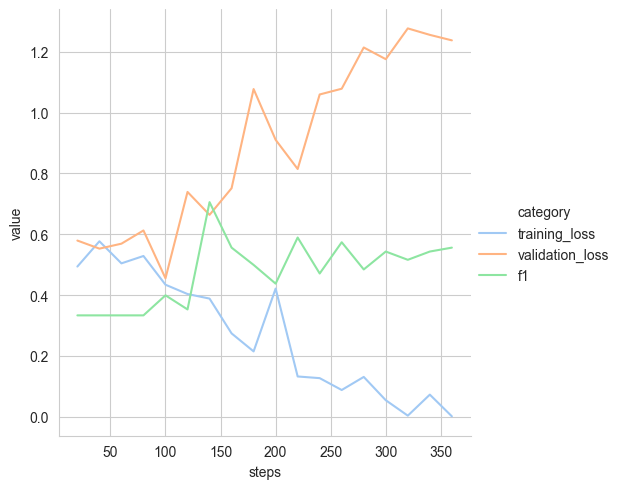

In [80]:
sns.set_style("whitegrid") 
sns.relplot(pola_bert, x="steps", y = "value", hue="category", kind="line", 
           palette = "pastel")

This graph shows, that the validation loss has an upward trend almost from the beginning, while training loss decreases. 